# フィラデルフィア半導体株指数 日足 メディアン統計

In [1]:
import sys
path_up = '..'
if not path_up in sys.path:
    sys.path.append(path_up)

In [2]:
import matplotlib.font_manager as fm
import matplotlib.pyplot as plt
import mplfinance as mpf
import numpy as np
import pandas as pd
import seaborn as sns
import yfinance as yf

from funcs.technical import calc_robust_bollinger

code = 'SOX'
symbol = '^%s' % code
#symbol = 'USDJPY=X'
ticker = yf.Ticker(symbol)
df = ticker.history(period='1y', interval='1d')
df

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2024-03-21 00:00:00-04:00,4949.149902,4983.459961,4890.479980,4897.879883,0,0.0,0.0
2024-03-22 00:00:00-04:00,4876.009766,4945.640137,4868.950195,4908.259766,0,0.0,0.0
2024-03-25 00:00:00-04:00,4838.310059,4937.350098,4836.439941,4891.490234,0,0.0,0.0
2024-03-26 00:00:00-04:00,4920.209961,4943.250000,4849.810059,4851.879883,0,0.0,0.0
2024-03-27 00:00:00-04:00,4902.279785,4903.180176,4815.060059,4899.950195,0,0.0,0.0
...,...,...,...,...,...,...,...
2025-03-14 00:00:00-04:00,4542.709961,4608.689941,4534.709961,4598.790039,0,0.0,0.0
2025-03-17 00:00:00-04:00,4587.109863,4703.770020,4587.049805,4663.970215,0,0.0,0.0
2025-03-18 00:00:00-04:00,4618.040039,4628.649902,4562.040039,4589.029785,0,0.0,0.0


In [3]:
df0 = ticker.history(period='3y', interval='1d')
df0

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2022-03-21 00:00:00-04:00,3413.659912,3450.459961,3365.250000,3423.239990,0,0.0,0.0
2022-03-22 00:00:00-04:00,3421.939941,3485.229980,3417.110107,3445.850098,0,0.0,0.0
2022-03-23 00:00:00-04:00,3411.679932,3457.250000,3359.379883,3360.320068,0,0.0,0.0
2022-03-24 00:00:00-04:00,3398.010010,3533.580078,3384.300049,3532.719971,0,0.0,0.0
2022-03-25 00:00:00-04:00,3525.959961,3535.409912,3466.989990,3525.340088,0,0.0,0.0
...,...,...,...,...,...,...,...
2025-03-14 00:00:00-04:00,4542.709961,4608.689941,4534.709961,4598.790039,0,0.0,0.0
2025-03-17 00:00:00-04:00,4587.109863,4703.770020,4587.049805,4663.970215,0,0.0,0.0
2025-03-18 00:00:00-04:00,4618.040039,4628.649902,4562.040039,4589.029785,0,0.0,0.0


## Moving Median

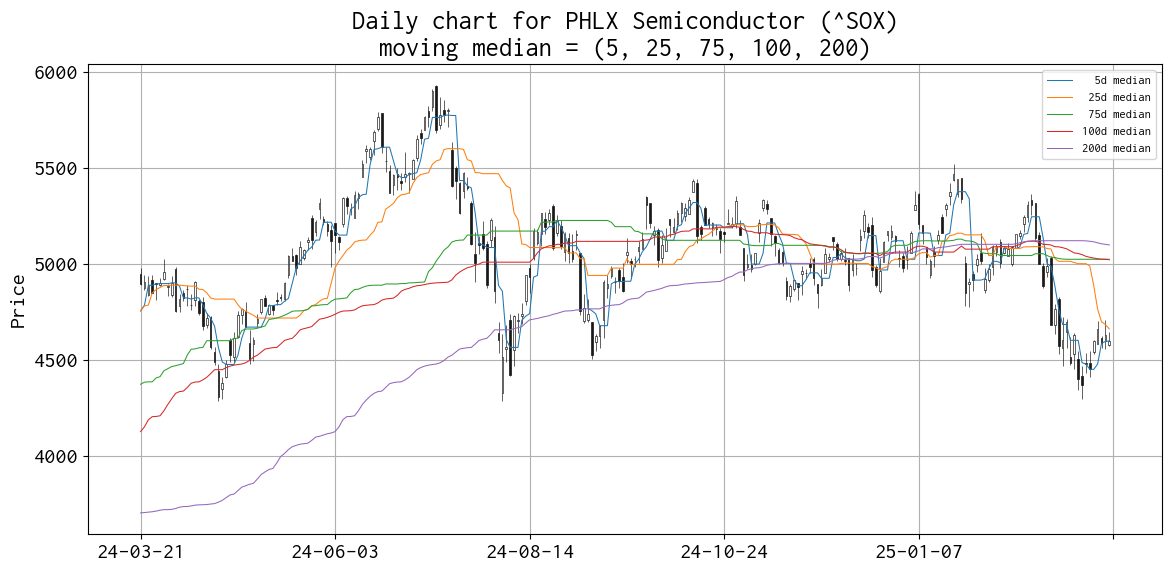

In [4]:
FONT_PATH = "../fonts/RictyDiminished-Regular.ttf"
fm.fontManager.addfont(FONT_PATH)

# FontPropertiesオブジェクト生成（名前の取得のため）
font_prop = fm.FontProperties(fname=FONT_PATH)
font_prop.get_name()

plt.rcParams['font.family'] = font_prop.get_name()
plt.rcParams['font.size'] = 16

fig, ax = plt.subplots(figsize=(12, 6))
"""
fig = plt.figure(figsize=(12, 8))
ax = dict()
n = 2
gs = fig.add_gridspec(
    n, 1,
    wspace=0.0, hspace=0.0,
    height_ratios=[3 if i == 0 else 1 for i in range(n)]
)
for i, axis in enumerate(gs.subplots(sharex='col')):
    ax[i] = axis
    ax[i].grid()
"""

mm005 = df0['Close'].rolling(5).median()
mm025 = df0['Close'].rolling(25).median()
mm075 = df0['Close'].rolling(75).median()
mm100 = df0['Close'].rolling(100).median()
mm200 = df0['Close'].rolling(200).median()

apds  = [
    mpf.make_addplot(mm005[df.index], width=0.75, label='  5d median', ax=ax),
    mpf.make_addplot(mm025[df.index], width=0.75, label=' 25d median', ax=ax),
    mpf.make_addplot(mm075[df.index], width=0.75, label=' 75d median', ax=ax),
    mpf.make_addplot(mm100[df.index], width=0.75, label='100d median', ax=ax),
    mpf.make_addplot(mm200[df.index], width=0.75, label='200d median', ax=ax),
]   

mpf.plot(
    df, type='candle', style='default',
    datetime_format='%y-%m-%d',
    addplot=apds,
    xrotation=0,
    ax=ax,
)
ax.set_title('Daily chart for %s (%s)\nmoving median = (5, 25, 75, 100, 200)' %(ticker.info['longName'], symbol))
ax.grid()
ax.legend(loc='best', fontsize=9)

plt.tight_layout()
plt.savefig('report_daily_chart_median_%s.png' % code)
plt.show()

In [5]:
df.tail(2)

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2025-03-19 00:00:00-04:00,4598.919922,4709.379883,4558.589844,4634.529785,0,0.0,0.0
2025-03-20 00:00:00-04:00,4579.060059,4648.459961,4575.450195,4601.370117,0,0.0,0.0


In [6]:
df.tail(2)['Close']

Date
2025-03-19 00:00:00-04:00    4634.529785
2025-03-20 00:00:00-04:00    4601.370117
Name: Close, dtype: float64

In [7]:
df.tail(2)['Close'].diff()

Date
2025-03-19 00:00:00-04:00          NaN
2025-03-20 00:00:00-04:00   -33.159668
Name: Close, dtype: float64

In [8]:
df['Close'].tail(1) - df['Open'].tail(1)

Date
2025-03-20 00:00:00-04:00    22.310059
dtype: float64

In [9]:
df['Close'].rolling(9).median().tail()

Date
2025-03-14 00:00:00-04:00    4487.850098
2025-03-17 00:00:00-04:00    4487.850098
2025-03-18 00:00:00-04:00    4487.850098
2025-03-19 00:00:00-04:00    4589.029785
2025-03-20 00:00:00-04:00    4589.029785
Name: Close, dtype: float64

In [10]:
df['Close'].rolling(13).median().tail()

Date
2025-03-14 00:00:00-04:00    4598.790039
2025-03-17 00:00:00-04:00    4598.790039
2025-03-18 00:00:00-04:00    4589.029785
2025-03-19 00:00:00-04:00    4589.029785
2025-03-20 00:00:00-04:00    4598.790039
Name: Close, dtype: float64

In [11]:
df['Close'].rolling(26).median().tail()

Date
2025-03-14 00:00:00-04:00    4939.849854
2025-03-17 00:00:00-04:00    4827.814941
2025-03-18 00:00:00-04:00    4733.770020
2025-03-19 00:00:00-04:00    4693.770020
2025-03-20 00:00:00-04:00    4675.360107
Name: Close, dtype: float64

In [12]:
df['Close'].rolling(52).median().tail()

Date
2025-03-14 00:00:00-04:00    5028.519775
2025-03-17 00:00:00-04:00    5024.004883
2025-03-18 00:00:00-04:00    5020.770020
2025-03-19 00:00:00-04:00    5020.770020
2025-03-20 00:00:00-04:00    5017.945068
Name: Close, dtype: float64

## Robust Bollinger's bands

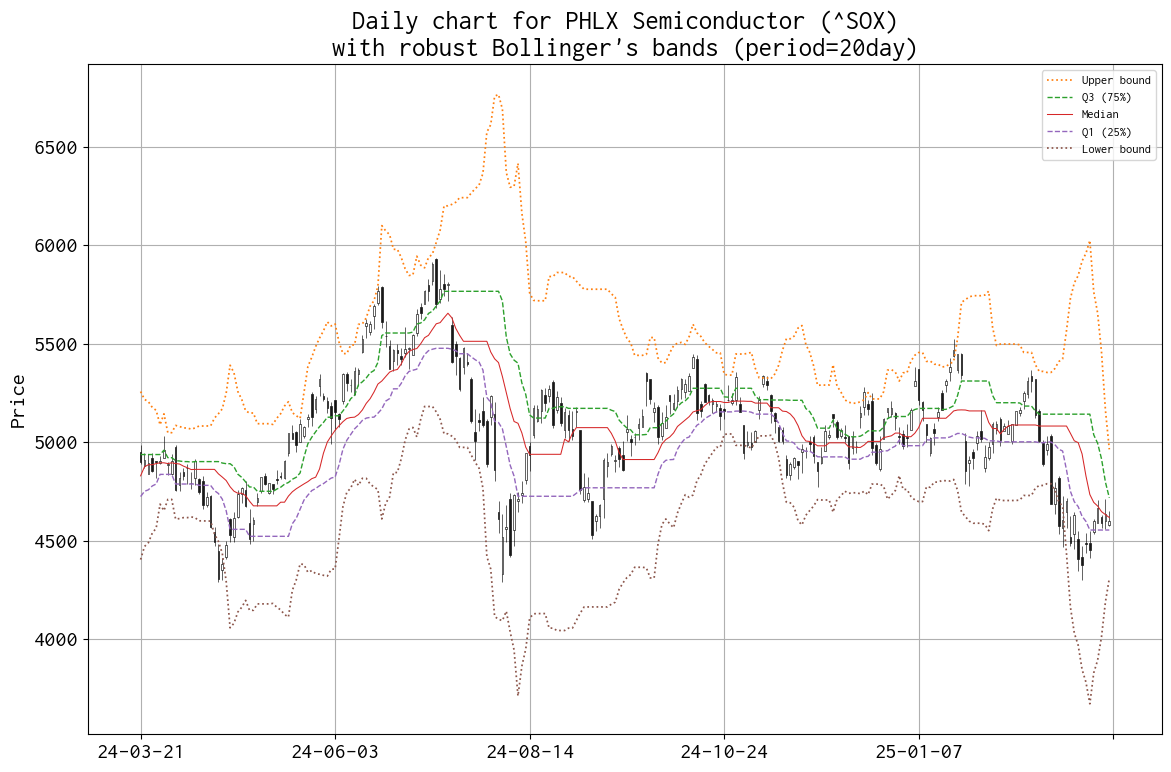

In [13]:
FONT_PATH = "../fonts/RictyDiminished-Regular.ttf"
fm.fontManager.addfont(FONT_PATH)

# FontPropertiesオブジェクト生成（名前の取得のため）
font_prop = fm.FontProperties(fname=FONT_PATH)
font_prop.get_name()

plt.rcParams['font.family'] = font_prop.get_name()
plt.rcParams['font.size'] = 16

fig, ax = plt.subplots(figsize=(12, 8))

# Bollinger bands
period = 20
mv_median = df0['Close'].rolling(period).median()
mv_q1 = df0['Close'].rolling(period).quantile(.25)
mv_q3 = df0['Close'].rolling(period).quantile(.75)
mv_iqr = mv_q3 - mv_q1
mv_lower = mv_q1 - mv_iqr * 1.5
mv_upper = mv_q3 + mv_iqr * 1.5

apds  = [
    mpf.make_addplot(mv_upper[df.index], width=1.25, color='C1', linestyle='dotted', label='Upper bound', ax=ax),
    mpf.make_addplot(mv_q3[df.index], width=1, color='C2', linestyle='dashed', label='Q3 (75%)', ax=ax),
    mpf.make_addplot(mv_median[df.index], width=0.75, color='C3', label='Median', ax=ax),
    mpf.make_addplot(mv_q1[df.index], width=1, color='C4', linestyle='dashed', label='Q1 (25%)', ax=ax),
    mpf.make_addplot(mv_lower[df.index], width=1.25, color='C5', linestyle='dotted', label='Lower bound', ax=ax),
]   

mpf.plot(
    df, type='candle', style='default',
    addplot=apds,
    datetime_format='%y-%m-%d',
    xrotation=0,
    ax=ax,
)

ax.grid()
ax.legend(loc='best', fontsize=9)

try:
    ax.set_title('Daily chart for %s (%s)\nwith robust Bollinger bands (period=%dday)' % (ticker.info['longName'], symbol, period))
except KeyError:
    ax.set_title('Daily chart for %s\nwith robust Bollinger bands (period=%dday)' % (symbol, period))

plt.tight_layout()
plt.savefig('report_daily_chart_bollinger_robust_%s.png' % code)
plt.show()

## ヒストグラム

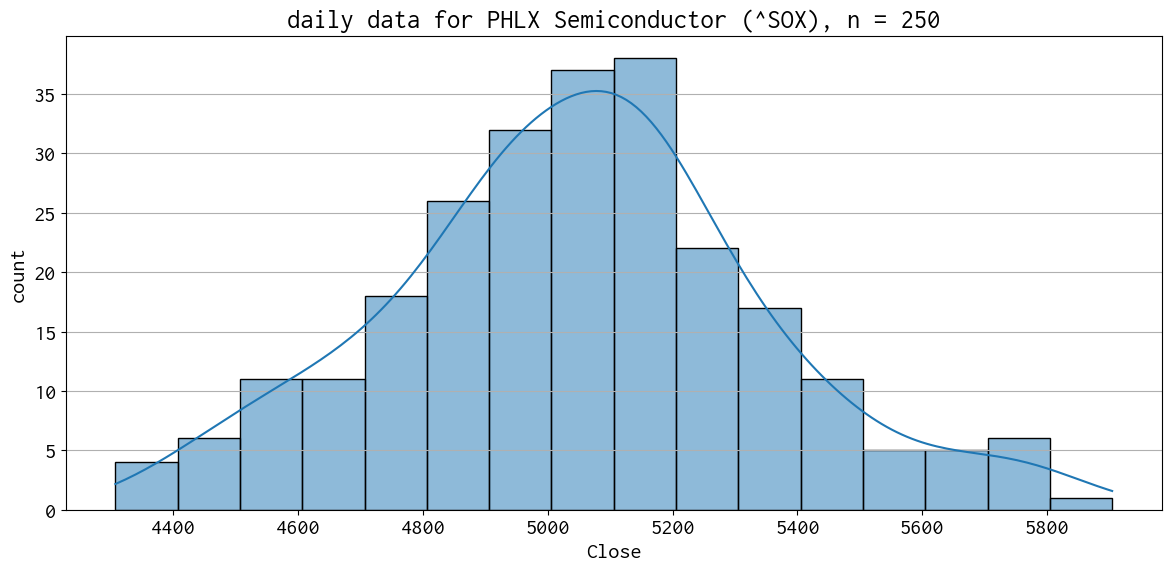

In [15]:
plt.rcParams['font.size'] = 16
fig = plt.figure(figsize=(12, 6))
#ax = fig.add_axes(111)
ax = fig.add_subplot(111)

sns.histplot(
    df['Close'],
    kde=True,
    ax=ax
)

ax.set_xlabel("Close")
ax.set_ylabel("count")
ax.set_title('daily data for %s (%s), n = %d' % (ticker.info['longName'], symbol, len(df)))
ax.grid(axis = 'y')

plt.tight_layout()
plt.savefig('report_daily_histogram_%s.png' % code)
plt.show()